In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import boutdata
from boututils.options import BOUTOptions
from boutdata.collect import create_cache
import argparse
import os
import time as tm
from datetime import datetime
from boutdata.data import BoutOptionsFile


/home/mike/pyenvs/base-3.12.5/lib/python3.12/site-packages/boutdata/data.py:765: AlwaysWarning: While building x, y, z coordinate arrays, an exception occured: [Errno 2] No such file or directory: '"g3e4f1-lores_widev2_nonortho_xpoint_allf.nc"'
Evaluating non-scalar options not available
  alwayswarn(


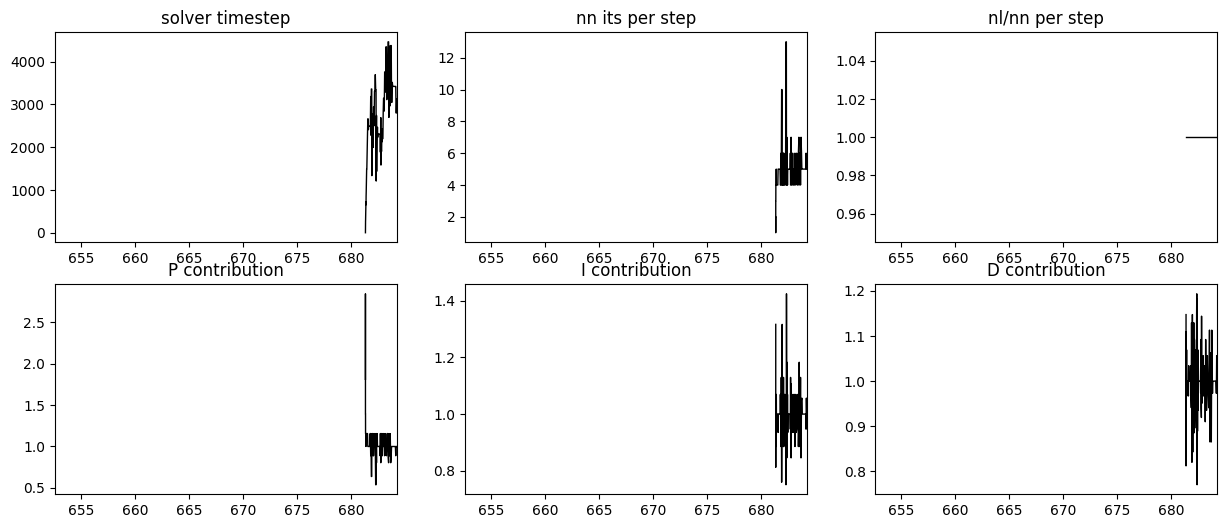

In [105]:
path = r"/home/mike/work/cases/2025-updateST40/upst5ab-Nnorm_x10"

logpath = os.path.join(path, "BOUT.log.0")
lines = []

with open(logpath) as f:
    lines = f.read().splitlines()
    
time = []
timestep = []
nniters = []
nliters = []
reason = []
steps_since_fail = []
step_counter = 0
snes_prints_found = False

for line in lines:
    if "Time: " in line:
        if "SNES failures" in line:
            step_counter = 0
        else:
            step_counter += 1
            
        steps_since_fail.append(step_counter)
        
        line = line.split(",")
        time.append(float(line[0].split(":")[-1].strip()))
        timestep.append(float(line[1].split(":")[-1].strip()))
        nniters.append(float(line[2].split(":")[-1].strip()))
        nliters.append(float(line[3].split(":")[-1].strip()))
        reason.append(float(line[4].split(":")[-1].strip()))
        
        snes_prints_found = True
        
        
snes_time = np.array(time) * (1/Omega_ci) * 1000
snes_timestep = np.array(timestep)
snes_nniters = np.array(nniters)
snes_nliters = np.array(nliters)
snes_reason = np.array(reason)
snes_steps_since_fail = np.array(steps_since_fail)
snes_nonlinear_linear_ratio = snes_nliters / snes_nniters


opts = BoutOptionsFile(os.path.join(path, "BOUT.inp"))
target_its = float(opts["solver"]["target_its"])
kP = float(opts["solver"]["kP"])
kI = float(opts["solver"]["kI"])
kD = float(opts["solver"]["kD"])

nn_its_prev = np.roll(snes_nniters, 1)
nn_its_prev2 = np.roll(snes_nniters, 2)

facP = (target_its / snes_nniters)**kP
facI = (nn_its_prev / snes_nniters)**kI
facD = (nn_its_prev * nn_its_prev / snes_nniters / nn_its_prev2)**kD


fig, axes = plt.subplots(2,3, figsize = (3*5, 3*2))
style = dict(lw = 1, c = "k")

ax = axes[0,0]
ax.set_title("solver timestep")
ax.plot(snes_time, snes_timestep, **style)

ax = axes[0,1]
ax.set_title("nn its per step")
ax.plot(snes_time, snes_nniters, **style)

ax = axes[0,2]
ax.set_title("nl/nn per step")
ax.plot(snes_time, snes_nonlinear_linear_ratio, **style)

ax = axes[1,0]
ax.set_title("P contribution")
ax.plot(snes_time, facP, **style)

ax = axes[1,1]
ax.set_title("I contribution")
ax.plot(snes_time, facI, **style)

ax = axes[1,2]
ax.set_title("D contribution")
ax.plot(snes_time, facD, **style)

for ax in axes.flatten():
    ax.set_xlim(652.6, snes_time[-1])

In [73]:
len(snes_time)

703

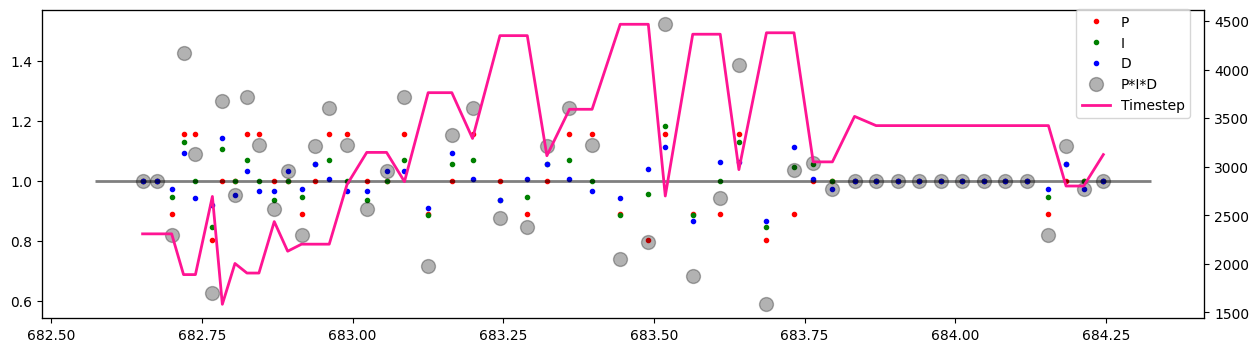

In [118]:
fig, ax = plt.subplots(figsize = (15,4))

select = slice(len(snes_time)-50, None)

ax.plot(snes_time[select], facP[select], "o", lw = 1, alpha = 1,  ms = 3, c = "r", label = "P")
ax.plot(snes_time[select], facI[select], "o", lw = 1, alpha = 1,  ms = 3, c = "g", label = "I")
ax.plot(snes_time[select], facD[select], "o", lw = 1, alpha = 1,  ms = 3, c = "b", label = "D")

ax.plot(snes_time[select], (facP * facI * facD)[select], "o", lw = 1, c = "k", alpha = 0.3, ms = 10, label = "P*I*D")
# ax.grid()
ax2 = ax.twinx()
# ax2.plot(snes_time[select], snes_nniters[select], lw = 2, c = "purple", zorder = 0)
# ax2.hlines(target_its, *ax.get_xlim(), lw = 2, colors = "purple", ls = "--")

ax3 = ax.twinx()
ax3.plot(snes_time[select], snes_timestep[select], lw = 2, c = "deeppink", label = "Timestep")


for ax_sel in [ax2]:
    # ax3.tick_params(axis="y", which = "both", left = False, right=False, labelright=False)
    ax_sel.yaxis.set_visible(False)

ax.hlines(1, *ax.get_xlim(), lw = 2, colors = "black", alpha = 0.5, ls = "-")
fig.legend(loc = "upper left", bbox_to_anchor=(0.81,0.9))

In [ ]:
ax.hlines

In [21]:
snes_timestep

array([], dtype=float64)

In [ ]:



# print(opts.as_tree())

/home/mike/pyenvs/base-3.12.5/lib/python3.12/site-packages/boutdata/data.py:765: AlwaysWarning: While building x, y, z coordinate arrays, an exception occured: [Errno 2] No such file or directory: '"g3e4f1-lores_widev2_nonortho_xpoint_allf.nc"'
Evaluating non-scalar options not available
  alwayswarn(


In [2]:
neutrals = True
plot = False
save = True
path = r"/home/mike/work/cases/2025-updateST40/upst4a-2e19_lores_base_afn_new_ena"

tstart = tm.time()
    
if path == ".":
    casename = os.path.basename(os.getcwd())
else:
    casename = os.path.basename(path)
print(f"Reading {casename}")
print("Calculating...", end = "")

# Reading with cache for extra speed
cache = create_cache(path, "BOUT.dmp")
print("..cache", end="")
def get_var(name, guards = True):
        
    if guards:
        yguards = "include_upper"
        xguards = True
    else:
        yguards = False
        xguards = False
    
    return  boutdata.collect(
        name,
        path = path,
        yguards = yguards,  # Akways with guards to minimise mistakes
        xguards = xguards,  # Always with guards to minimise mistakes
        strict = True,   # To prevent reading wrong variable by accident
        info = False,
        datafile_cache = cache
    ).squeeze()

# Get normalisations and geometry
Nnorm = get_var("Nnorm")
Tnorm = get_var("Tnorm")
Omega_ci = get_var("Omega_ci")
MYG = get_var("MYG")
ixseps1 = get_var("ixseps1")
jyseps1_2 = get_var("jyseps1_2")
jyseps2_2 = get_var("jyseps2_2")
dx = get_var("dx")
dy = get_var("dy")
dz = get_var("dz")
J = get_var("J")
dv = dx * dy * dz * J

dv_noguards = get_var("dx", guards = False) * get_var("dy", guards = False) * get_var("dz", guards = False) * get_var("J", guards = False)



# Get process parameters
t = get_var("t") * (1/Omega_ci) * 1000

# Sometimes the last timestep is bugged and like 1e20 higher, not sure why
if t[-1] > t[-2]*1000:
    skip = slice(None,-2)
    print("\nLast timestep is bugged, skipping last timestep")
else:
    skip = slice(None,None)

Ne = get_var("Ne") * Nnorm
Nn = get_var("Nd") * Nnorm
Te = get_var("Te") * Tnorm
Tn = get_var("Td") * Tnorm

res = {}
ddt_params = ["ddt(Pe)","ddt(Pd+)", "ddt(Pd)", "ddt(Ne)", "ddt(Nn)", "ddt(NVd+)", "ddt(NVd)"]

for param in ddt_params:
    try:
        res[param] = get_var(param, guards = False)
    except:
        res[param] = np.zeros_like(get_var("Ne", guards = False))


dv = dx * dy * dz * J

# Get solver parameters
wtime = get_var("wtime")

cvode = True
try:
    nliters = get_var("cvode_nliters")
    nniters = get_var("cvode_nniters")
    nfails = get_var("cvode_num_fails")
    lorder = get_var("cvode_last_order")
except:
    cvode = False
    nliters = np.zeros_like(t)
    nniters = np.zeros_like(t)
    nfails = np.zeros_like(t)
    lorder = np.zeros_like(t)


print("..data", end="")

# Calculate locations
# [t, x, y]
j2_2g = jyseps2_2 + MYG * 3
j1_2g = jyseps1_2 + MYG * 3
y_omp = int((j2_2g - j1_2g) / 2) + j1_2g
x_sep = ixseps1
x_ng = slice(2,-2)   # No guards in  X

# First row of plots
Ne_sep = Ne[:,x_sep,y_omp]
# Ntot = ((Ne[:, x_ng, :] + Nn[:, x_ng, :]) * dv).sum(axis = (1,2))
Ne_target = np.max((0.5*(Ne[:,x_ng, -2] + Ne[:,x_ng,-3])), axis = 1)
Nn_target = np.max((0.5*(Nn[:,x_ng, -2] + Nn[:,x_ng,-3])), axis = 1)
Tn_target = np.max((0.5*(Tn[:,x_ng, -2] + Tn[:,x_ng,-3])), axis = 1)
Te_target = np.max((0.5*(Te[:,x_ng, -2] + Te[:,x_ng,-3])), axis = 1)
Tn_sol = Tn[:, -3, y_omp]
Te_sol = Te[:, -3, y_omp]
Tn_core_avg = np.mean(Tn[:, slice(3,x_sep)], axis = (1,2))

def append_first(x):
    return np.insert(x,0,x[0])
# Second row of plots
stime = np.diff(t, prepend = t[0]*0.99)
ms_per_24hrs = (stime) / (wtime/(60*60*24))  # ms simulated per 24 hours

if cvode:
    lratio = np.diff(nliters, prepend=nliters[1]*0.99) / np.diff(nniters, prepend=nniters[1]*0.99)   # Ratio of linear to nolinear iterations
    fails = np.diff(nfails, prepend = nfails[1]*0.99)
    fails[0] = fails[1]
    lorder[0] = lorder[1]
ms_per_24hrs[0] = ms_per_24hrs[1]

# ddt
for param in res:

    res[param] = (res[param] * dv_noguards[None, :, :]) / np.sum(dv_noguards)   # Volume weighted
    res[param] = np.sqrt(np.mean(res[param]**2, axis = (1,2)))  # RMS
    res[param] = np.convolve(res[param], np.ones(1), "same")    # Moving average with window of 1

print("..calculations", end="")


Reading upst4a-2e19_lores_base_afn_new_ena
Calculating.....cache

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

..figures..saved figures

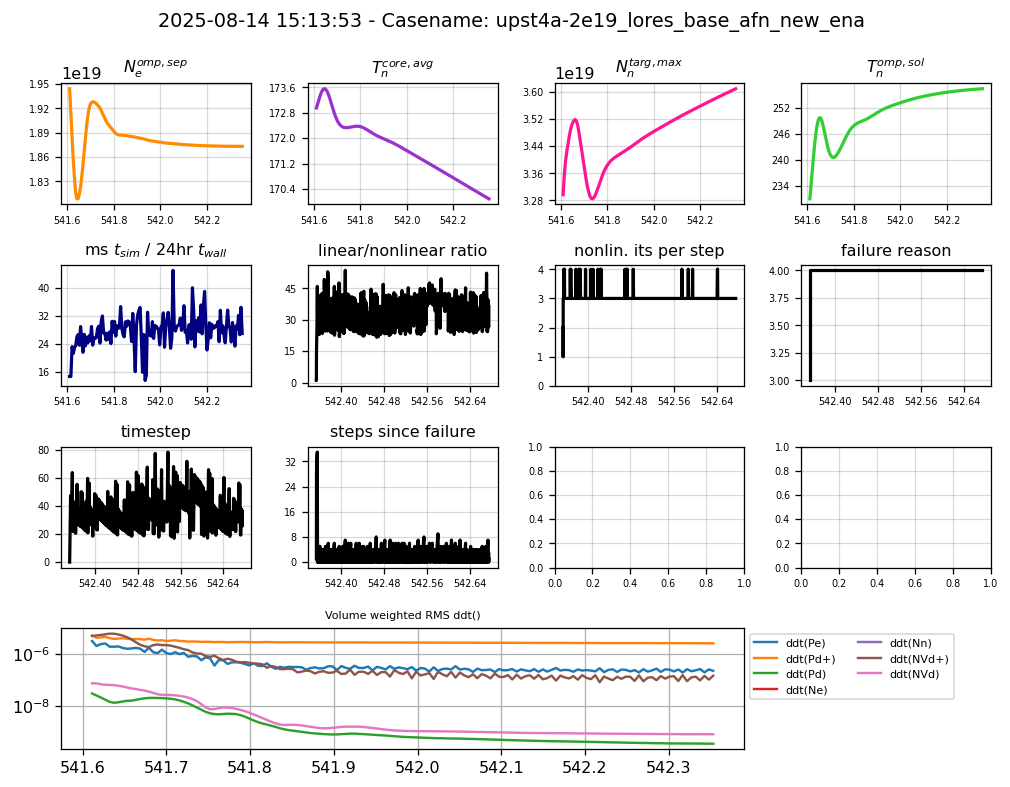

In [ ]:
# Plotting
if plot is True or save is True:
    scale = 1.3
    figsize = (8*scale,6*scale)
    dpi = 150/scale
    title_font_size = "medium"
    # fig, axes = plt.subplots(2,4, figsize=figsize, dpi = dpi)
    
    # Use GridSpec for flexible layout
    fig = plt.figure(figsize=figsize, dpi=dpi)
    gs = fig.add_gridspec(4, 4)  # 3 rows, 4 columns
    

    # Original two rows of 4
    axes = np.empty((3, 4), dtype=object)
    for r in range(3):
        for c in range(4):
            axes[r, c] = fig.add_subplot(gs[r, c])
            
    big_ax = fig.add_subplot(gs[3, slice(None,3)])  

    fig.subplots_adjust(wspace = 0.3, hspace=0.5, top = 0.85)
    
    now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    fig.suptitle(f"{now} - Casename: {casename}", y = 0.93)

    lw = 2
    axes[0,0].plot(t[skip], Ne_sep[skip], c = "darkorange", lw = lw)
    axes[0,0].set_title("$N_{e}^{omp,sep}$", fontsize = title_font_size)
    
    ## Physics
    if neutrals is True:
        
        axes[0,3].plot(t[skip], Tn_sol[skip], c = "limegreen", lw = lw)
        axes[0,3].set_title("$T_{n}^{omp,sol}$", fontsize = title_font_size)
        
        axes[0,1].plot(t[skip], Tn_core_avg[skip], c = "darkorchid", lw = lw)
        axes[0,1].set_title("$T_{n}^{core,avg}$", fontsize = title_font_size)

        axes[0,2].plot(t[skip], Nn_target[skip], c = "deeppink", lw = lw)
        axes[0,2].set_title("$N_{n}^{targ,max}$", fontsize = title_font_size)
    
    else:
        
        axes[0,1].plot(t[skip], Te_sol[skip], c = "limegreen", lw = lw)
        axes[0,1].set_title("$T_{e}^{omp,sol}$", fontsize = title_font_size)
        
        axes[0,2].plot(t[skip], Ne_target[skip], c = "deeppink", lw = lw)
        axes[0,2].set_title("$N_{e}^{targ,max}$", fontsize = title_font_size)
        
        axes[0,3].plot(t[skip], Te_target[skip], c = "darkorchid", lw = lw)
        axes[0,3].set_title("$T_{e}^{targ,max}$", fontsize = title_font_size)
        
        
        
    ## Speed
    axes[1,0].plot(t[skip], ms_per_24hrs[skip], c = "navy", lw = lw)
    axes[1,0].set_title("ms $t_{sim}$ / 24hr $t_{wall}$", fontsize = title_font_size)
    
    # #CVODE
    if cvode:
        axes[1,1].plot(t[skip], lratio[skip], c = "k", lw = lw)
        axes[1,1].set_title("linear/nonlinear", fontsize = title_font_size)
        axes[1,2].plot(t[skip], np.clip(fails, 0, np.max(fails))[skip], c = "k", lw = lw)
        axes[1,2].set_title("nfails", fontsize = title_font_size)
        axes[1,2].set_ylim(0,None)
        axes[1,3].plot(t[skip], lorder[skip], c = "k", lw = lw)
        axes[1,3].set_title("order", fontsize = title_font_size)
        
    ## SNES    
    elif snes_prints_found:
        
        axes[1,1].plot(snes_time[skip], snes_nonlinear_linear_ratio[skip], c = "k", lw = lw)
        axes[1,1].set_title("linear/nonlinear ratio", fontsize = title_font_size)
        axes[1,2].plot(snes_time[skip], snes_nniters[skip], c = "k", lw = lw)
        axes[1,2].set_title("nonlin. its per step", fontsize = title_font_size)
        axes[1,2].set_ylim(0,None)
        axes[1,3].plot(snes_time[skip], snes_reason[skip], c = "k", lw = lw)
        axes[1,3].set_title("failure reason", fontsize = title_font_size)
        
        axes[2,0].plot(snes_time[skip], snes_timestep[skip], c = "k", lw = lw)
        axes[2,0].set_title("timestep", fontsize = title_font_size)
        axes[2,1].plot(snes_time[skip], snes_steps_since_fail[skip], c = "k", lw = lw)
        axes[2,1].set_title("steps since failure", fontsize = title_font_size)
    
    else:
        print("Non-CVODE solver detected without diagnose=True under [solver], skipping diagnostic plots")
        
    ## ddts
    for param in res:
        big_ax.plot(t[skip], res[param][skip], label=param)
        big_ax.set_yscale("log")
        big_ax.grid()
        big_ax.set_title("Volume weighted RMS ddt()", fontsize = "x-small")
        big_ax.legend(fontsize = "x-small", loc = "upper left", bbox_to_anchor=(1,1), ncols = 2)

    for i in [0,1,2]:
        for ax in axes[i,:]:
            ax.grid(c = "k", alpha = 0.15)
            ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(min_n_ticks=3, nbins=5))
            ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(min_n_ticks=3, nbins=5))
            # ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(4))
            ax.tick_params(axis='x',labelsize=6)
            ax.tick_params(axis='y',labelsize=6)
            
    # fig.tight_layout()
    
    print("..figures", end="")
    
    if plot is True:
        plt.show()  
        
    if save:
        fig.savefig(f"mon_{casename}.png", bbox_inches="tight", pad_inches = 0.2)
        print("..saved figures", end="")

In [20]:
res

{}